In [1]:
import numpy as np
import rebound
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, root, least_squares
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import CubicSpline

In [2]:
default_configs = {
    'planet_num': 2,
    'planet_mass': [1e-8, 1e-8],
    'kappa': 2,
    'inner_period': 2*np.pi,
    'C': [],
    'target_mean_anomaly': 4*np.pi,
    'init_time_step': 0.5,
    'bisection_tol': 1e-12,
}

In [3]:
def integrate_one_cycle(sim, configs):
    time_step = configs['init_time_step']
    bisection_tol = configs['bisection_tol']
    target_mean_anomaly = configs['target_mean_anomaly']
    current_mean_anomaly = 0
    N_peri = 0
    counter = 0
    M = [0]
    times = [sim.t]
    
    while True:
        # Integrate by stepping one time
        time_now = sim.t + time_step
        sim.integrate(time_now)
        
        # Getting the actual current mean anomaly
        current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi

        # Correct mean anomaly
        if current_mean_anomaly - M[-1] < 0:
            N_peri += 1
            current_mean_anomaly = sim.particles[1].M + N_peri * 2*np.pi 
            M.append(current_mean_anomaly)
            # print(f"Starting {N_peri}")
        else:
            M.append(current_mean_anomaly)

        # Store time
        times.append(sim.t)

        # Find the precise 16pi
        if current_mean_anomaly > target_mean_anomaly:
            target_time = bisection_sin_M(sim, target_mean_anomaly, times[-2], times[-1], M[-2], M[-1], bisection_tol)
            sim.integrate(target_time)
            return sim, target_time, times, M
            # return M, times, target_time


def bisection_sin_M(sim, target, a, b, Ma, Mb, tol=1e-9, doom_counts=10000):
    """
    Bisection method on sin M. The function terminates after a certain attempt.
    """    
    func = CubicSpline([a, b], [Ma, Mb], bc_type='natural')

    while True:
        half = (a + b)/2
        
        # If the target lies on the first half
        if (func(half) - target) > 0:
            a = a
            b = half
    
        # If the target lies on the second half
        if (func(half) - target) < 0:
            a = half
            b = b
    
        # print(np.abs(fa - fb))
        
        if np.abs(a - b) < 1e-8:
            # print(half, func(half))
            break

    return half

def wrap_angles(angles):
    for i, ang in enumerate(angles):
        while ang > np.pi or ang <= -np.pi:
            if ang < 0:
                ang += 2*np.pi
            elif ang > 0:
                ang -= 2*np.pi

        angles[i] = ang

    return angles

def wrap_angle(ang):
    while ang > np.pi or ang <= -np.pi:
        if ang < 0:
            ang += 2*np.pi
        elif ang > 0:
            ang -= 2*np.pi
    
    return ang

In [4]:
def init_simulation(theta, configs):
    inner_period = configs['inner_period']
    
    init_e = 10 ** np.array(theta[0:2], dtype=np.float64)
    init_M = theta[2]
    init_pomega = -theta[3]
    
    sim = rebound.Simulation()

    sim.add(m=1)
    sim.add(m=configs['planet_mass'][0], P=inner_period, e=init_e[0])
    sim.add(m=configs['planet_mass'][1], P=inner_period*configs['kappa'], pomega=init_pomega, M=init_M, e=init_e[1])
    
    return sim


def optimizing_function(theta, configs):
    init_theta = theta
    init_sim = init_simulation(init_theta, configs)

    final_sim, target_time, _, _ = integrate_one_cycle(init_sim, configs)
    final_sim.move_to_hel()
    

    final_theta = np.log10(final_sim.particles[1].e), np.log10(final_sim.particles[2].e), wrap_angle(final_sim.particles[2].M), wrap_angle(final_sim.particles[1].pomega - final_sim.particles[2].pomega)

    theta_diff = np.asarray(final_theta) - np.asarray(init_theta)
    # print(init_theta, final_theta)
    # print(theta_diff)

    diff = np.sum(theta_diff ** 2)
    # print(diff)
    return diff

    # return theta_diff

[-6.24511318 -9.82436848 -0.0098754  -0.02267236] 0.0004931838466748685
[-5.92889514 -8.80333899 -0.01078754 -0.02536435] 0.0004990414645482683
[-2.87772518 -7.81408611 -0.00846486 -0.04364611] 0.0004984558823557085
[-2.4101035  -6.82887114 -0.00979919 -0.05048272] 0.0004985241816267452
[-1.63963538 -5.95754306 -0.01120635 -0.07471612] 0.0004985024357884475
[-1.50555592 -5.02185087 -0.01554063 -0.08231846] 0.0004988497783211866
[-1.34980899 -4.13810784 -0.01584944 -0.09391668] 0.0005009746883201662
[-1.04923249 -5.11258414 -0.05764118 -0.04161048] 0.0005034231862675439
[-1.04461514 -5.53110281 -0.05637879 -0.03982215] 0.0005478384921505164
[-1.04461514 -5.53110281 -0.05637879 -0.03982215]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.99), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


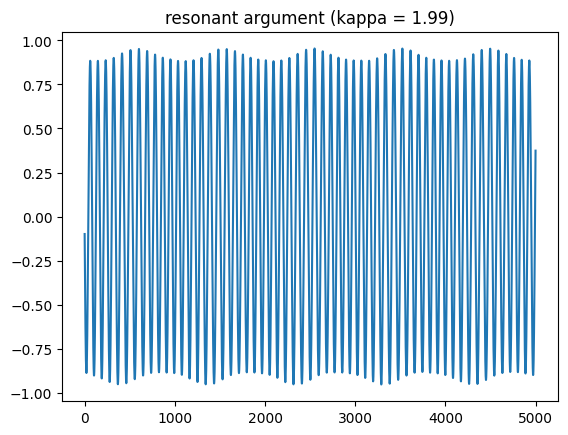

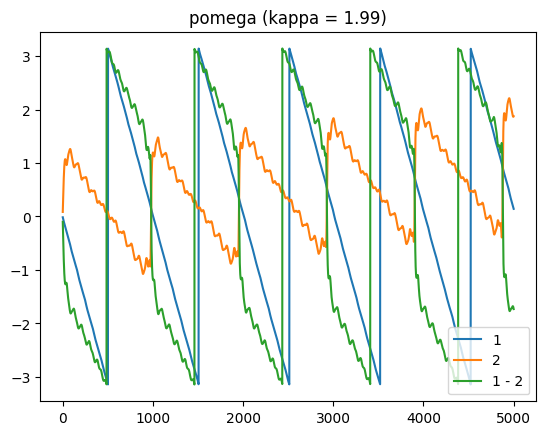

[-6.46962048e+00 -9.71564249e+00 -8.94067939e-03 -1.00274140e-02] 0.0003113422647844341
[-6.47952994 -8.69223447 -0.01017318 -0.01058577] 0.0003211306447611182
[-3.58107018 -7.69820286 -0.01338233 -0.01382697] 0.000318121101631955
[-2.26595925 -6.73423486 -0.01706879 -0.0177245 ] 0.0003183847731792843
[-1.46594946 -5.94543988 -0.03090519 -0.01863505] 0.0003184106050619657
[-1.0921687  -5.72816614 -0.03340639 -0.01870623] 0.0003184204541102937
[-1.0462831  -5.54001849 -0.03324227 -0.02027336] 0.0003187653175298961
[-1.03868456 -5.61540405 -0.03340876 -0.02068932] 0.00032216044364916476
[-1.03604898 -5.1808369  -0.03776904 -0.02440767] 0.0003566739665280178
[-1.03604898 -5.1808369  -0.03776904 -0.02440767]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.992), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


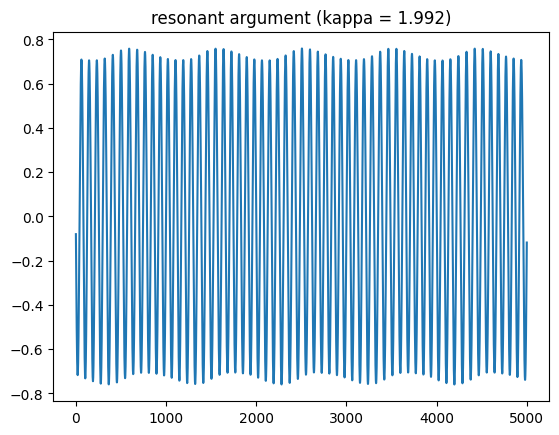

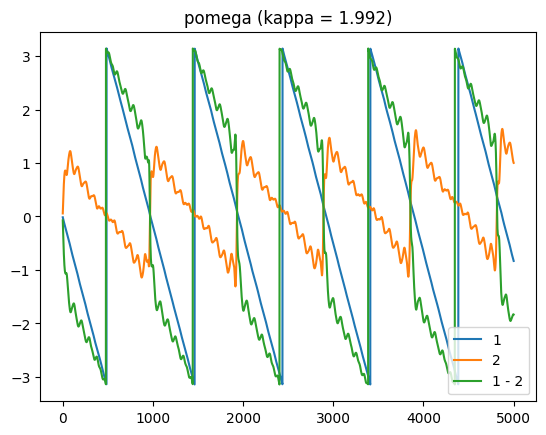

[-6.30055370e+00 -9.56571235e+00 -2.38678716e-02 -9.03816758e-03] 0.0001780531187058954
[-3.99254267 -8.56956946 -0.03380755 -0.01066187] 0.0001787165364650817
[-4.07096548 -7.56877047 -0.03633841 -0.01106863] 0.0001788561521183943
[-1.48091965 -6.79646332 -0.04115293 -0.01743829] 0.00017874381873856594
[-1.50621792 -5.78168597 -0.04279549 -0.01925451] 0.00017876503119236596
[-1.22940001 -5.06701285 -0.05866033 -0.01868973] 0.00017880209829451024
[-1.17361707 -4.18320265 -0.06521485 -0.02050921] 0.0001793886590271132
[-1.03121112 -5.08090799 -0.03341023 -0.02382031] 0.00018148729874387787
[-1.02766118 -4.78155473 -0.03501322 -0.02483867] 0.0002066844415506699
[-1.02766118 -4.78155473 -0.03501322 -0.02483867]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.994), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


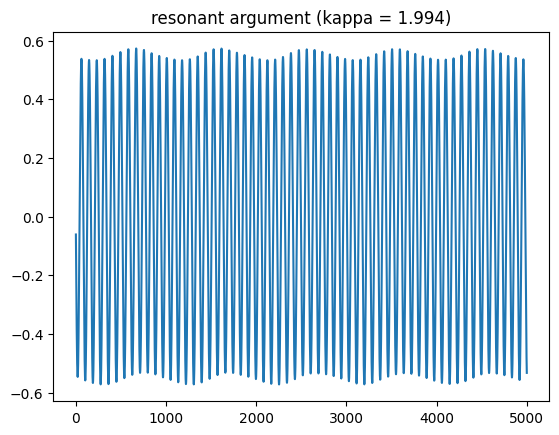

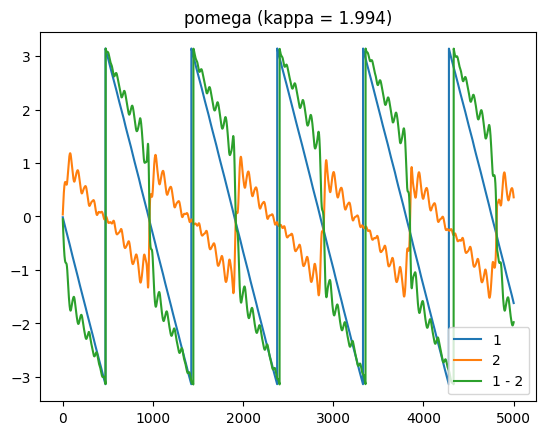

[-6.15969270e+00 -9.37058337e+00 -9.28094511e-03 -2.31463309e-02] 7.781008211839173e-05
[-6.08640037 -8.38165985 -0.0099751  -0.02460382] 7.991605661045928e-05
[-2.90423407 -7.39063533 -0.01129125 -0.03618015] 7.927031315204818e-05
[-2.88944036 -6.39078709 -0.01239269 -0.03836482] 7.932008436692907e-05
[-1.22681664 -5.87667728 -0.03809898 -0.01306124] 7.927853028480257e-05
[-1.09888754 -5.26410501 -0.03243189 -0.02288224] 7.930106179103498e-05
[-1.02850045 -5.29370217 -0.0318121  -0.02517547] 7.945728542374392e-05
[-1.02212594 -5.26777012 -0.03190279 -0.02550966] 8.104712507981238e-05
[-1.01945029 -4.84692478 -0.03286324 -0.02587464] 9.757619012698436e-05
[-1.01945029 -4.84692478 -0.03286324 -0.02587464]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.996), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


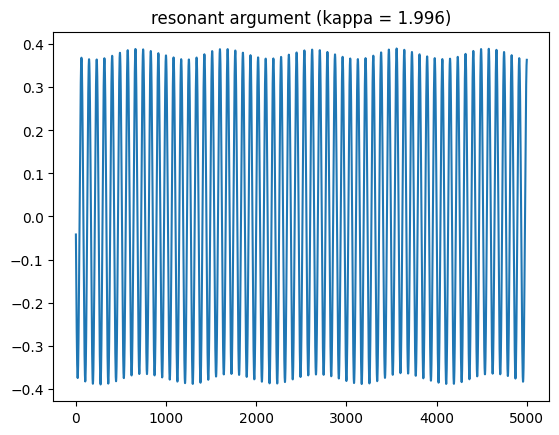

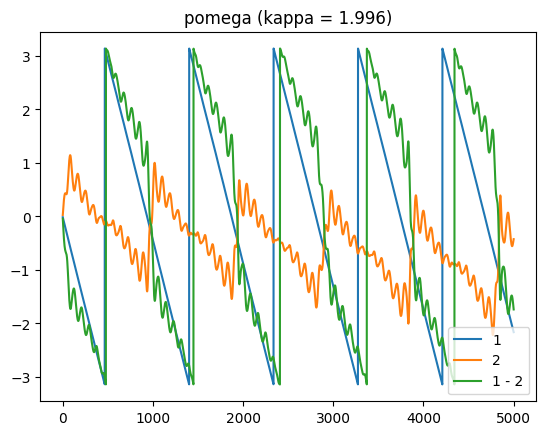

[-6.09099604e+00 -9.06713384e+00 -8.54322820e-03 -9.08145395e-03] 1.968912713903361e-05
[-3.97336283 -8.07755741 -0.00866834 -0.01523784] 1.9758161303792578e-05
[-3.98401451 -7.07646795 -0.00932408 -0.01608195] 1.9806300895064825e-05
[-1.87497339 -6.15449105 -0.01224457 -0.0238806 ] 1.978053926199559e-05
[-1.27437223 -5.482977   -0.01852819 -0.02180831] 1.9782823886249535e-05
[-1.06193469 -5.15215687 -0.02933986 -0.02370339] 1.9790089488028294e-05
[-1.01866199 -5.11940407 -0.0284187  -0.02503668] 1.9866600778225707e-05
[-1.01409803 -4.92837265 -0.02664237 -0.02340881] 2.0640564043501737e-05
[-1.01139045 -4.73217429 -0.02792825 -0.02411754] 2.905302117256227e-05
[-1.01139045 -4.73217429 -0.02792825 -0.02411754]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(1.998), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


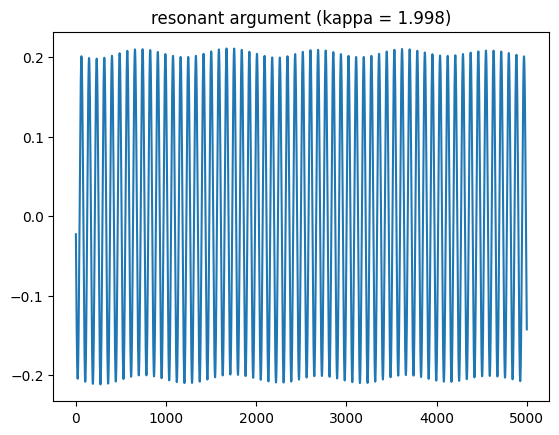

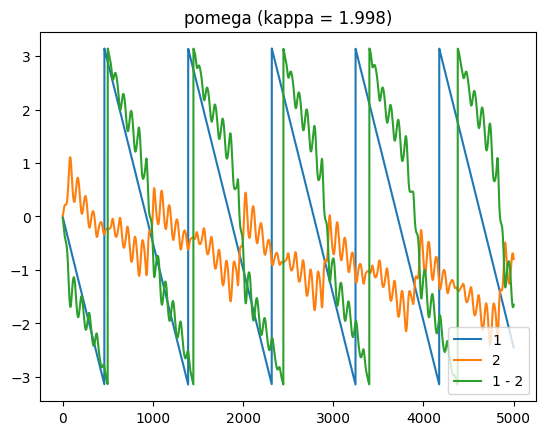

[-1.5 -1.5  0.   0. ] 4.4570641144987167e-29
[-1.5375 -1.5     0.      0.    ] 1.1537090738857298e-29
[-1.5375e+00 -1.5000e+00  0.0000e+00  2.5000e-04] 1.916374761679158e-15
[-8.00000000e-01 -1.76320741e+00  2.03492477e-03  2.79785734e-04] 3.328981566464208e-19
[-8.00000000e-01 -1.76730136e+00  2.00849259e-03  2.90944418e-04] 1.7803719865339006e-17
[-8.00000000e-01 -1.76712325e+00 -7.60568158e-04  5.49051500e-04] 1.2787777614990673e-15
[-8.00000000e-01 -1.76708923e+00 -7.01059750e-04  5.46413558e-04] 1.4132550970382002e-13
[-8.00000000e-01 -1.76750919e+00 -6.39460453e-04  5.73018332e-04] 1.4065118496021545e-11
[-8.00000000e-01 -1.77156816e+00 -6.55873176e-04  5.98207612e-04] 1.2681751177486516e-09
[-8.00000000e-01 -1.77156816e+00 -6.55873176e-04  5.98207612e-04]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.0), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol':

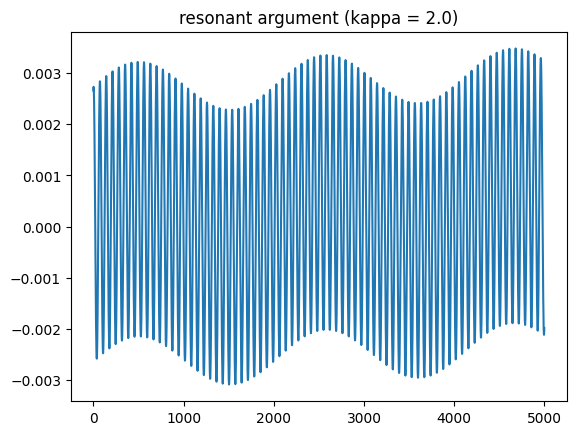

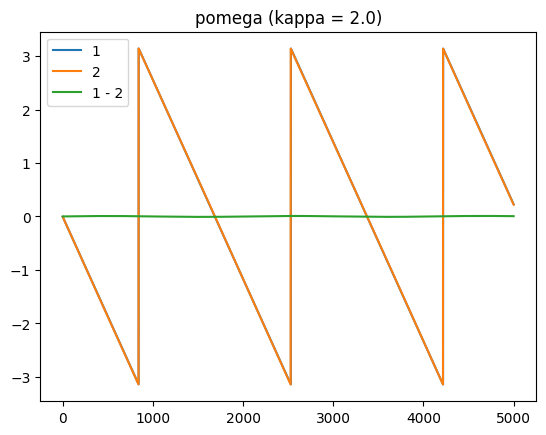

[-0.91239043 -9.82202063  0.01347418  0.01014325] 1.9174166107144833e-05
[-0.98175942 -9.57199852  0.01398349  0.01041751] 1.9426894427904798e-05
[-0.98883198 -8.82019297  0.01530856  0.01039292] 1.9682608467133e-05
[-0.98808791 -7.79692891  0.01634016  0.01264141] 1.9698962672193534e-05
[-0.96923058 -6.33987415  0.01788553  0.01467504] 1.9699613673189402e-05
[-0.98698013 -5.75292694  0.01826386  0.01543619] 1.9692316082719857e-05
[-0.99179263 -5.00313356  0.01907518  0.01612628] 1.9623365446231722e-05
[-0.99749635 -5.06622909  0.01943168  0.01637296] 1.8914468241707407e-05
[-0.99624059 -5.22095858  0.02147016  0.01896318] 1.261405039556905e-05
[-0.99624059 -5.22095858  0.02147016  0.01896318]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.002), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


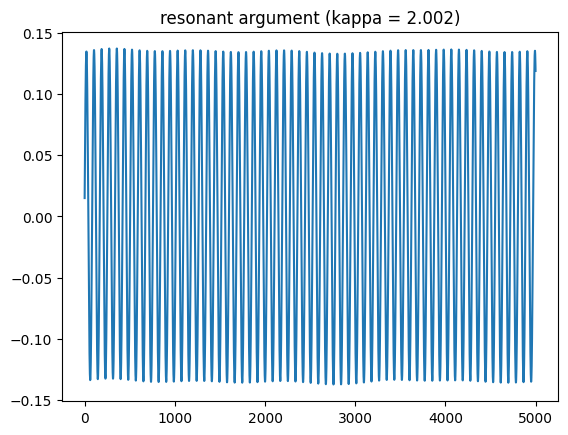

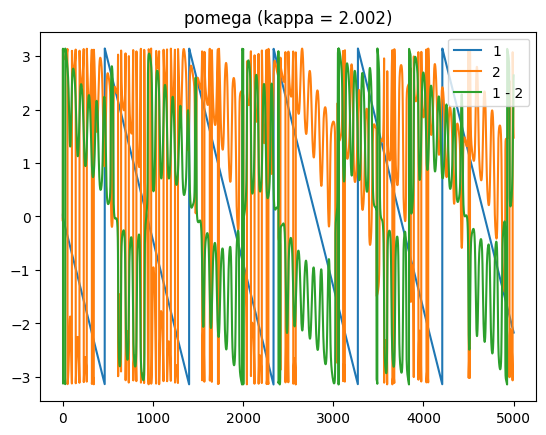

[-9.91699133e-01 -9.84932492e+00  1.41164103e-02  7.24369784e-03] 0.00014150054983949777
[-9.63321490e-01 -9.67808559e+00  1.51551852e-02  7.32542320e-03] 7.787776278532556e-05
[-9.80174459e-01 -9.06484295e+00  1.60495470e-02  7.63050554e-03] 7.858047526205722e-05
[-0.96560343 -7.69560774  0.0178582   0.00829175] 7.870632008398056e-05
[-0.96369219 -6.66586539  0.01713732  0.01143397] 7.86399980728542e-05
[-0.97106349 -5.80397503  0.01776935  0.01200151] 7.862827494179412e-05
[-0.98807559 -5.64714391  0.01815368  0.01196791] 7.849009418735498e-05
[-0.98965635 -5.09860832  0.01849932  0.01232039] 7.711546596900497e-05
[-0.98882426 -5.15316745  0.02031952  0.01466206] 6.412110221489499e-05
[-0.98882426 -5.15316745  0.02031952  0.01466206]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.004), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


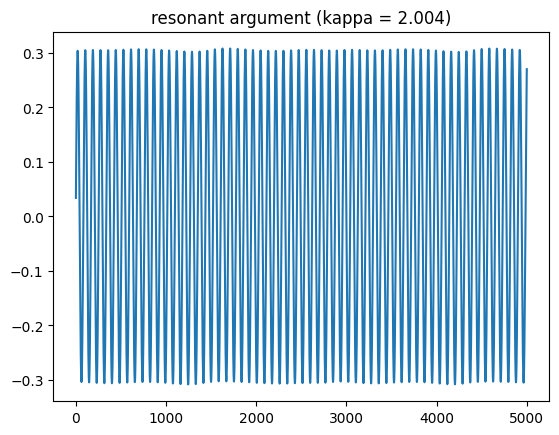

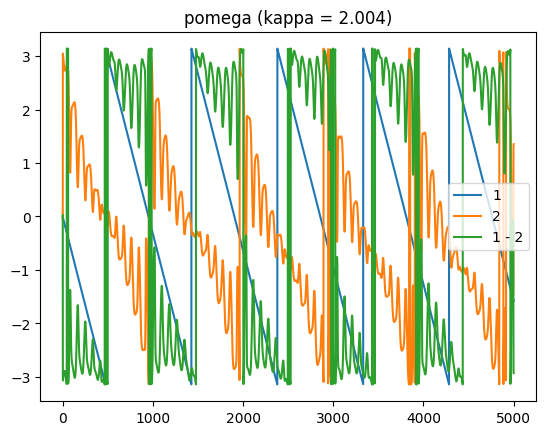

[-8.79665582e-01 -1.00000000e+01  1.40960025e-02  9.46484057e-03] 0.00017966047179245945
[-9.65528512e-01 -1.00000000e+01  1.44695966e-02  8.87308994e-03] 0.00017054589200849116
[-9.82010182e-01 -1.00000000e+01  1.50110610e-02  8.23222844e-03] 0.0001824869652972727
[-9.83633468e-01 -1.00000000e+01  1.56561916e-02  6.30688709e-03] 0.00017504509561578306
[-9.83783034e-01 -1.00000000e+01  1.55264562e-02  6.15730757e-03] 0.00018972937037875192
[-9.83796898e-01 -1.00000000e+01  1.55533739e-02  6.15976695e-03] 0.00031780518903087694
[-9.83779539e-01 -1.00000000e+01  1.55518572e-02  6.16108187e-03] 0.00019593250395763418
[-9.83605469e-01 -1.00000000e+01  1.54374930e-02  6.10083727e-03] 0.00019788556291924013
[-9.81865754e-01 -1.00000000e+01  1.48424077e-02  6.03869298e-03] 0.00019168668632517567
[-9.81865754e-01 -1.00000000e+01  1.48424077e-02  6.03869298e-03]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.006), 'inner_period': 6.2831853071795

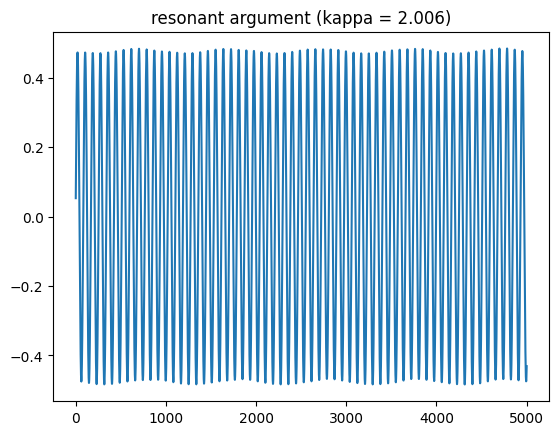

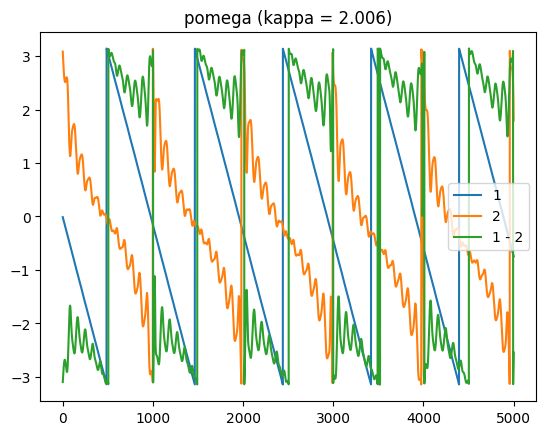

[-0.93179186 -9.80413962  0.01006877  0.02461151] 0.0005557213019411254
[-0.93352888 -9.78374733  0.0104311   0.02471828] 0.00030631777728752434
[-0.93476257 -8.78623339  0.01191214  0.0269664 ] 0.0003132505911587406
[-0.80103974 -7.12220714  0.01030375  0.03093914] 0.00031392615719927374
[-0.80054181 -6.11895082  0.01098315  0.03114831] 0.00031391901248355744
[-0.8        -5.11842044  0.01181043  0.03125223] 0.0003138765030301087
[-0.85927139 -4.30651661  0.01729363  0.00570172] 0.0003132038087595672
[-0.97481854 -5.18914974  0.02036161  0.00794576] 0.0003104432710312507
[-0.97450333 -5.09082998  0.02026137  0.00832713] 0.00028523232587941743
[-0.97450333 -5.09082998  0.02026137  0.00832713]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.008), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly': 12.566370614359172, 'init_time_step': 0.5, 'bisection_tol': 1e-12}


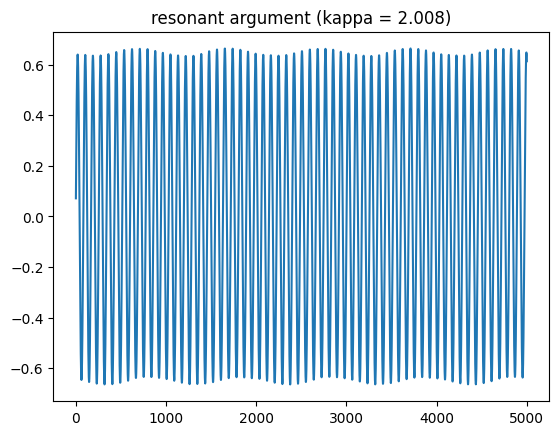

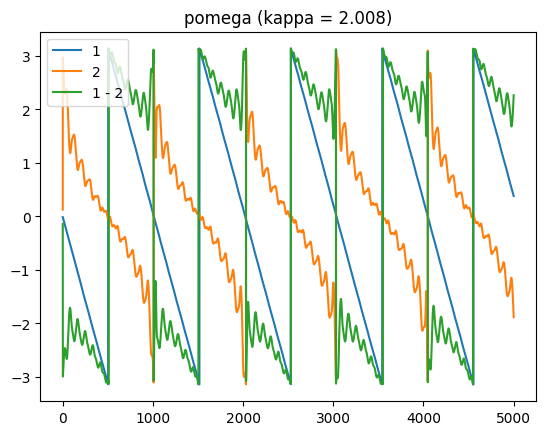

[ -0.8        -10.           0.02059144   0.04153757] 0.0005087356982606116
[ -0.94121146 -10.           0.01878463   0.04042464] 0.00048582199195987616
[-9.66723290e-01 -1.00000000e+01  2.02177661e-02  5.48090659e-03] 0.000480783882163049
[-9.69521112e-01 -1.00000000e+01  2.09788919e-02  5.39401936e-03] 0.0004853950787404682
[-9.69811076e-01 -1.00000000e+01  2.09637367e-02  5.32779177e-03] 0.0005049213406613619
[-9.69831679e-01 -1.00000000e+01  2.09588902e-02  5.32503890e-03] 0.000546990467864065
[-9.69817185e-01 -1.00000000e+01  2.09499398e-02  5.32542804e-03] 0.0005383388963412711
[-9.69651015e-01 -1.00000000e+01  2.08734031e-02  5.30022920e-03] 0.0005064813745244071
[-9.67989329e-01 -1.00000000e+01  2.02241608e-02  5.15496809e-03] 0.0004852621208225309
[-9.67989329e-01 -1.00000000e+01  2.02241608e-02  5.15496809e-03]
{'planet_num': 2, 'planet_mass': [np.float64(0.0001), np.float64(0.0001)], 'kappa': np.float64(2.01), 'inner_period': 6.283185307179586, 'C': [], 'target_mean_anomaly'

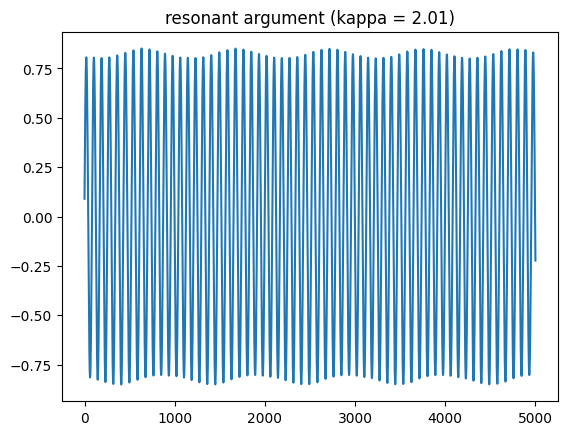

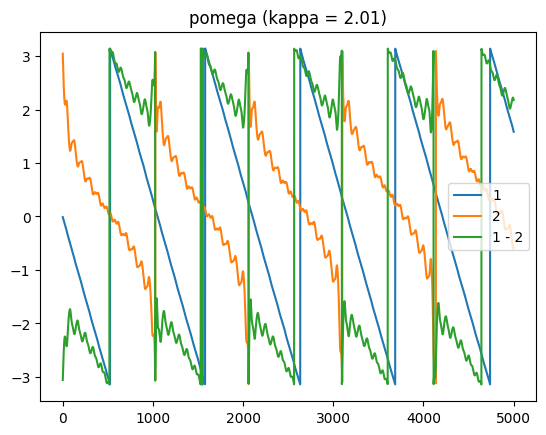

In [5]:
# Mass Continuation then Kappa

mass_cands = 10 ** np.arange(-12., -3., 1.)
kappa_cands = np.linspace(1.990, 2.010, 11)

bounds = [(-10, -0.8), (-10, -0.8), (-np.pi, np.pi), (-np.pi, np.pi)]

for j, kappa in enumerate(kappa_cands):
    init_theta = [-1.5, -1.5, 0, 0]
    
    for i, m in enumerate(mass_cands):
        m_configs = default_configs.copy()
        m_configs['planet_mass'] = [m, m]
        m_configs['kappa'] = kappa
    
        res = minimize(optimizing_function, x0=init_theta, method='Nelder-Mead', bounds=bounds, args=(m_configs,))
        init_theta = res.x
        print(res.x, res.fun)
    
    print(res.x)

    marks = np.arange(0, 5001, 1)

    sim = init_simulation(res.x, m_configs)
    _, target_time, _, _ = integrate_one_cycle(sim, m_configs)
    print(m_configs)
    
    angle_hist = np.zeros(len(marks))
    pomega_1_hist = np.zeros(len(marks))
    pomega_2_hist = np.zeros(len(marks))
    
    for i, _ in enumerate(marks):
        sim.integrate(sim.t + target_time)
        sim.t = 0
        sim.move_to_hel()
        
        angle_hist[i] = sim.particles[1].l - 2*sim.particles[2].l + sim.particles[1].pomega
    
        pomega_1_hist[i] = sim.particles[1].pomega
        pomega_2_hist[i] = sim.particles[2].pomega
    
        # print(sim.particles[1].l, sim.particles[2].l, sim.particles[1].pomega)

    plt.plot(wrap_angles(angle_hist))
    plt.title(f'resonant argument (kappa = {m_configs['kappa']})')
    plt.show()
    plt.plot(wrap_angles(pomega_1_hist), label='1')
    plt.plot(wrap_angles(pomega_2_hist), label='2')
    plt.plot(wrap_angles(pomega_1_hist - pomega_2_hist), label='1 - 2')
    plt.legend()
    plt.title(f'pomega (kappa = {m_configs['kappa']})')
    plt.show()
        